In [236]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [244]:
trees_df = pd.read_csv('county_tree_temp_dwp_prcp_Kent.csv')

In [245]:
trees_df.head()

,year,state_code,county_code,species,latitude,longitude,volume,Biomass,number_trees,mean_temp,mean_dwp,mean_prcp
0,2001,1,1,loblolly pine,32.578953,-86.593001,580.837421,12112.015753,148,67.470830,54.867025,0.153781
1,2001,1,1,red maple,32.620470,-86.587013,7.226856,182.733664,3,68.050000,54.900915,0.158415
2,2001,1,1,slash pine,32.515568,-86.626175,0.000000,16.737962,6,68.050000,54.900915,0.158415
3,2001,1,1,sweetgum,32.569998,-86.627121,161.481322,3499.375783,17,66.428324,54.806024,0.145440
4,2001,1,1,yellow-poplar,32.638274,-86.539808,35.165761,806.265958,8,68.050000,54.900915,0.158415


<Figure size 720x720 with 0 Axes>

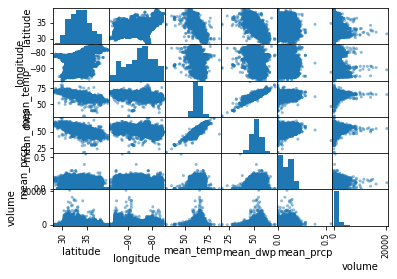

In [258]:
X = trees_df[['species','latitude','longitude','mean_temp','mean_dwp','mean_prcp']]
yb = trees_df['Biomass']
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.3, shuffle=True, random_state=42)
plt.figure(figsize = (10,10))
scatter_matrix(trees_df[['latitude','longitude','mean_temp','mean_dwp','mean_prcp','volume']].loc[trees_df.species == 'loblolly pine'])
plt.show()

In [222]:
columns = ['year','state_code','county_code','species','latitude',
           'longitude','volume','Biomass','number_trees','mean_temp',
           'mean_dwp','mean_prcp']
trees_no_time = trees_df.copy()
trees_no_time = trees_no_time[columns[3:]]

In [223]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

In [224]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    def fit(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            self.scaler.fit(Xreshape)
        else:
            self.scaler.fit(X[self.columns])
        return self
    def transform(self,X,y=None):
        if len(X[self.columns].shape) == 1:
            Xreshape = X[self.columns].to_numpy().reshape(-1,1)
            X[self.columns] = self.scaler.transform(Xreshape)
        else:
            X[self.columns] = self.scaler.transform(X[self.columns])
        return X
    
class Species(BaseEstimator, TransformerMixin):
    def __init__(self, tree):
        self.tree = tree
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.loc[X.species == self.tree]
        return X
    
class Species_enc(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = OneHotEncoder()
    def fit(self, X, y=None):
        self.enc.fit(X.species.to_numpy().reshape(-1,1))
        return self
    def transform(self, X, y=None):
        encoded = self.enc.transform(X.species.to_numpy().reshape(-1,1)).toarray()
        X = X.drop('species',axis=1).to_numpy()
        X = np.concatenate((X, encoded), axis=1)
        return X

In [227]:
pipe = Pipeline([('scaler', Scaler(['latitude','longitude','mean_temp','mean_dwp','mean_prcp'])),
                ('encoder', Species_enc())])

In [229]:
X_train_prp = pipe.fit_transform(X_train)

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [259]:
from sklearn.tree import DecisionTreeRegressor

In [260]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_prp,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')